# CS-502 Homework 2: Graph Neural Networks

Author: Mika Senghaas (mika.senghaas@epfl.ch)

This homework assignment implements a custom **graph neural network** (GNN) in pure [Pytorch](https://pytorch.org) and perform experiments on the [MUTAG]() dataset for graph classficiation of chemcical compounds. MUTAG consists of a collection of chemcical compounds, each represented as a graph. Here, *nodes* are atoms and identified by the atom type, *edges* are chemical bounds between the atoms with features indicating the chemical bond type. Each graph represents a chemical compound and is labelled as either *mutagenic* (positive) or *non-mutagenic* (negative) class. 

This notebook implements a graph neural network, which will be used in experiments to build a high-quality binary classifier for the mutagenicitiy of a chemical compound.

## Imports & Setup

We import the necessary modules and set global parameters. Note, that this notebook was run in the lastest minor release of Python `3.9`.

In [1]:
# Standard library
import sys
import json
import random

# External libraries
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset, random_split

In [2]:
print(sys.version)

3.9.16 (main, Dec 16 2022, 22:25:05) 
[Clang 14.0.0 (clang-1400.0.29.202)]


In [3]:
# Set seed for reproducibility
random.seed(1)
torch.manual_seed(1)

# Set plot styles
sns.set_style("darkgrid")

# Test data
test_x = torch.eye(3)
test_adj = torch.randint(0, 2, (3, 3)).float()

## Part 1: Implementing Different Graph Convolution and Pooling Layers

---

### Normal Convolution (Graph Convolution)

A regular graph convolution in the $l$-th layer computes the embedding of the $v$-th node, $\mathbf{h}_v$ through

$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \sum_{u\in N(v)} \frac{\mathbf{h}_u^{(l)}}{|N(v)|} + \mathbf{B}_l \mathbf{h}_v^{(l)} \right).
$$

Note, that here $\sigma$ is a non-linearity, $\mathbf{W}_l$ and $\mathbf{B}_l$ are both trainable weight matrices with dimension 
$\text{in\_features} \times \text{out\_features}$ and $N(v)$ is the set of adjacent nodes in the graph.

We can represent the average over the neighbourhood of node $v$ through a matrix product of the adjacency matrix $\mathbf{A}$ with the matrix $\mathbf{H}^{(l)}=\left[\mathbf{h}^{(l)}_1, ..., \mathbf{h}^{(l)}_{|V|}\right]$ holding all node embeddings in the $l$ layer (corrected by the inverse of the degree $\tilde{A}$ to obtain an average) as

$$
H^{(l+1)} = \sigma\left( \tilde{A}H^{(l)}W_l^\top + H^{(l)}B_l^\top \right).
$$

In [4]:
class GraphConv(nn.Module):
    """Basic graph convolutional layer implementing the simple neighborhood aggregation."""

    def __init__(self, in_features, out_features, activation=None, bias=False, debug=False):
        """
        Initialize the graph convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()
        
        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layers
        self.weight = nn.Linear(in_features, out_features, bias=False)
        self.bias = nn.Linear(in_features, out_features, bias=False)

        # Non-linear activation function (optional)
        self.activation = activation

    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # Neighbourhood aggregation
        adj = adj / adj.sum(1, keepdim=True).clamp(1)
        x_agg = adj @ x

        # Graph convolution
        x = self.weight(x_agg) + self.bias(x)

        # Apply non-linear activation if specified
        if self.activation:
            return self.activation(x)
        return x

In [5]:
# Test graph convolution
conv = GraphConv(3, 2)
out = conv(test_x, test_adj)

assert out.shape == (3, 2), f"Output shape shold be 3x2 but is {out.shape}"
print("Tests passed. ✅")

Tests passed. ✅


### GraphSAGE (Customised Aggregation)

GraphSAGE is a generalised version of the regular graph convolution, in which any type of aggregation can be applied to. Instead of adding the result of two matrix products and performing a non-linearity, here the original node embeddings are concatenated with the aggregated neighbourhood embeddings and then linearly transformed. The equation for the GraphSAGE layer is:

$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \cdot \mathrm{CONCAT} \left[\mathbf{h}_v^{(l)}, \mathrm{AGG} \left(\left\{\mathbf{h}_u^{(l)}, \forall u\in N(v) \right\}\right) \right] \right),
$$

where $v$ index the node, $l$ the layer, $\mathbf{h}$ are the node embeddings, $\sigma$ is a non-linearity, $N(v)$ is the set of neighbor of node $v$, and $\mathbf{W}$ is the trainable weight matrix of the layer. $\mathrm{CONCAT}$ is the concatenation operation, while $\mathrm{AGG}$ is an arbitrary aggregation function.

In [6]:
class GraphSAGEConv(nn.Module):
    """GraphSAGE convolutional layer."""
    
    def __init__(self, in_features, out_features, aggregation, activation=None, debug=False):
        """
        Initialize the GraphSAGE convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            aggregation (nn.Module or callable): aggregation function to apply, as x_agg = aggegration(x, adj).
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()

        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layer (no bias)
        self.weight = nn.Linear(2*in_features, out_features, bias=False)

        # Aggregation function
        self.aggregation = aggregation

        # Non-linear activation function (optional)
        self.activation = activation

    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (batch_dim, num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # Neighbourhood aggregation
        x_agg = self.aggregation(x, adj)

        # Concatenate node features and aggregated features
        x_cat = torch.cat([x, x_agg], dim=1)
        
        # Apply linear transformation
        x = self.weight(x_cat)

        # Apply non-linear activation if specified
        if self.activation:
            return self.activation(x)
        return x

In [7]:
# Test GraphSAGE
conv = GraphSAGEConv(3, 2, aggregation=lambda x, adj: adj @ x)
out = conv(test_x, test_adj)

assert out.shape == (3, 2), f"Output shape shold be 3x2 but is {out.shape}"
print("Tests passed. ✅")

Tests passed. ✅


### Attention-based Convolution



In [8]:
class AttentionGraphConvolution(nn.Module):
    """Attention-based convolutional layer."""
    
    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the attention-based convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()

        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layer (no bias)
        self.weight = nn.Linear(in_features, out_features, bias=False)
        self.weight2 = nn.Linear(2*in_features, 1, bias=False)

        # Non-linear activation function (optional)
        self.leaky_relu = nn.LeakyReLU()
        self.softmax = nn.Softmax(dim=1)
        self.activation = activation

    def forward(self, x, adj):
        """
        Perform an attention-based graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # Add self-loops to the adjacency matrix
        adj = torch.minimum(torch.full_like(adj, 1), adj + torch.eye(len(adj)))

        return ...

In [9]:
# Test attention-based convolution
conv = AttentionGraphConvolution(3, 2)
out = conv(test_x, test_adj)

### Mean Pooling

Mean pooling computes a graph level representation $\mathbf{h}_{\text{global}}$ as the mean (average) of all node features

$$
\textbf{h}_{\text{global}} = \frac{1}{N} \sum_{i=1}^N \mathbf{X}_i,
$$

where $\mathbf{X} \in \mathbb{R}^{N \times D}$ where $N$ is the number of nodes and $D$ is the feature dimension. Finally, $\mathbf{X}_i$ is node representation of the $i$-th node.

In [10]:
class MeanPooling(nn.Module):
    """Mean pooling layer."""

    def __init__(self):
        """Initialize mean pooling layer."""
        super().__init__()

    def forward(self, x):
        """
        Computes the average of all node features.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).

        Returns:
            Tensor: Aggregated node features of shape (in_features).
        """
        return torch.mean(x, dim=0)

In [11]:
# Simple test
x = torch.arange(12).reshape(4, 3).float()
maxpool = MeanPooling()
out = maxpool(x)

assert out.shape == (3,), "Output shape should be (3, ), but is {out.shape}"
assert torch.equal(out, torch.Tensor([4.5, 5.5, 6.5])), f"Output should be torch.Tensor([9, 10, 11]), but is {out}"
print("Tests passed. ✅")

Tests passed. ✅


### Max Pooling

Max pooling computes a graph level representation $\mathbf{h}_{\text{global}}$ by taking the maximum value from each feature dimension across all nodes in the graph-level representation

$$
\textbf{h}_{\text{global}, d} =  \max_{i=1}^N \mathbf{X}_{i, d}
$$

for each feature dimension $d$ and again $\mathbf{X} \in \mathbb{R}^{N \times D}$ where $N$ is the number of nodes and $D$ is the feature dimension and $\mathbf{X}_i$ is node representation of the $i$-th node.

In [12]:
class MaxPooling(nn.Module):
    """Max pooling layer."""

    def __init__(self):
        """Initialize mean pooling layer."""
        super().__init__()

    def forward(self, x):
        """
        Computes the max pool of all node features.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).

        Returns:
            Tensor: Max pooled node features of shape (in_features,).
        """

        return torch.max(x, dim=0).values

In [13]:
# Simple test
x = torch.arange(12).reshape(4, 3)
maxpool = MaxPooling()
out = maxpool(x)

assert out.shape == (3,), f"Output shape should be (3,), but is {out.shape}"
assert torch.equal(out, torch.arange(9, 12)), f"Output should be torch.Tensor([9, 10, 11]), but is {out}"
print("Tests passed. ✅")

Tests passed. ✅


## Part 2: Custom Network Design with Node Features

---

### Custom Network Architecture

This is a generic graph neural network for binary graph classification. It can be composed of the modules from above that can through user parameters for the number of node features as input, type and number of graph convolutional layers, pooling mechanism, dropout and batch normalisation.

In [14]:
class GNN(nn.Module):
    """Custom graph neural network model for binary graph prediction."""

    def __init__(self, 
        num_features: int, 
        conv_dims: list[int], 
        conv: nn.Module = GraphConv, 
        pooling: nn.Module = MeanPooling(), 
        activation: nn.Module or callable = nn.LeakyReLU(), 
        dropout=0.,
        ):
        """
        Initialize the GNN model for graph prediction.

        Args:
            num_features (int): Number of input node features.
            conv_dims (list of int): Number of hidden features in each graph convolution layers.
            activation (nn.Module or callable): Activation function to apply.
            dropout (float): Dropout probability. (optional)
        """
        super().__init__()
        
        # Save parameters
        self.dropout = dropout

        # TODO: fails if < 2 conv_dims
        # List of graph convolution layers
        self.convs = nn.ModuleList()
        self.convs.append(conv(num_features, conv_dims[0], activation))
        for i in range(len(conv_dims) - 2):
            self.convs.append(conv(conv_dims[i], conv_dims[i+1], activation))
        self.convs.append(conv(conv_dims[-2], conv_dims[-1]))

        """
        # Batch norm layers
        self.norms = nn.ModuleList()
        for dim in conv_dims:
            self.norms.append(nn.BatchNorm1d(dim))
        """
        
        # Pooling layer
        self.pooling = pooling

        # Fully connected layer
        self.fc = nn.Linear(conv_dims[-1] if conv_dims else num_features, 1)


    def forward(self, x, adj):
        """
        Perform forward pass for graph prediction.

        Args:
            x (Tensor): Input node features of shape (num_nodes, num_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).
        """

        # Graph convolution layers
        for conv in self.convs:
            x = F.dropout(conv(x, adj), p=self.dropout)

        # Pooling layer
        x = self.pooling(x)

        # Fully connected layer
        x = self.fc(x)

        return x

In [15]:
# Test architecture
model = GNN(3, [4, 4])
logits = model(test_x, test_adj)

assert logits.shape == (1,), f"Expected shape (1,), but got {logits.shape}"
print("Tests passed. ✅")

Tests passed. ✅


### Data Loading and Partitioning

This section loads and partitions the input data using the utility classes `torch.utils.data.Dataset` and `torch.utils.data.RandomDataSampler` to create random (but seeded) partitioning into training (70%), validation (15%) and testing (15%).

In [16]:
# Load the dataset
class MUTAGDataset(Dataset):
    def __init__(self, datapath: str):
        super().__init__()

        with open(datapath, "r") as f:
            raw = f.read()
        
        self.graphs = [json.loads(line) for line in raw.splitlines()]

    def __len__(self):
        """
        Returns the number of graphs in the dataset
        """
        return len(self.graphs)

    def __getitem__(self, idx):
        """
        Returns a single graph's node features, edge features, adjacency matrix and label

        Args:
            idx (int): Index of the graph to return.

        Returns:
            Tensor: Node features of shape (num_nodes, num_features).
            Tensor: Adjacency matrix of shape (num_nodes, num_nodes).
        """
        graph = self.graphs[idx]

        # Create adjacency matrix
        n = graph["num_nodes"]
        adj = torch.zeros((n, n))
        for i, j in zip(graph["edge_index"][0], graph["edge_index"][1]):
            adj[i, j] = 1
            adj[j, i] = 1

        node_feat = torch.Tensor(graph["node_feat"])
        edge_attr = torch.Tensor(graph["edge_attr"])
        label = torch.Tensor(graph["y"])

        return node_feat, edge_attr, adj, label

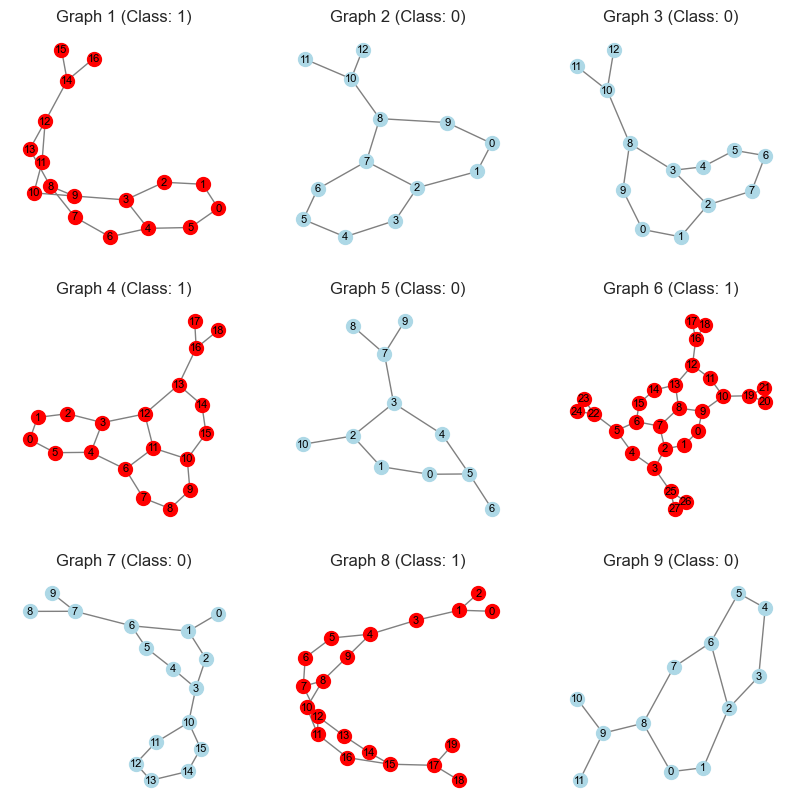

In [17]:
# Test dataset class
data = MUTAGDataset(datapath="data/mutag.jsonl")
node_feat, edge_attr, adj, label = data[0]

assert len(node_feat) == len(adj), f"Expected 17 nodes, but got {len(node_feat)}"

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
colors = ["lightblue", "red"]
styles = {
    "node_size": 100,
    "edge_color": "grey",
    "with_labels": True,
    "font_size": 8,
}
for i in range(9):
    _, _, adj, label = data[i]
    G = nx.from_numpy_array(adj.numpy())
    nx.draw(G, pos=nx.spring_layout(G), ax=ax[i//3, i%3],  node_color=colors[int(label.item())], **styles)
    ax[i//3, i%3].set_title(f"Graph {i+1} (Class: {int(label.item())})")

In [18]:
# Data splitting
n_val = int(0.2 * len(data))
n_test = int(0.2 * len(data))
n_train = len(data) - n_val - n_test
split_num_samples = [n_train, n_val, n_test]

# Split dataset randomly
train_data, val_data, test_data = random_split(data, split_num_samples)

In [19]:
# Quick EDA
print(f"Number of Training Graphs: {len(train_data)}")
print(f"Number of Validation Graphs: {len(val_data)}")
print(f"Number of Test Graphs: {len(test_data)}")

def compute_class_distribution(data):
    _, dist = torch.unique(torch.stack([label for _, _, _, label in data]), return_counts=True)
    return dist

def compute_pos_ratio(dist):
    return dist[1] / sum(dist)

# Compute class distribution
train_class_dist = compute_class_distribution(train_data)
val_class_dist = compute_class_distribution(val_data)
test_class_dist = compute_class_distribution(test_data)

# Compute positive weight (for binary cross entropy loss)
train_ratio = compute_pos_ratio(train_class_dist)
val_ratio = compute_pos_ratio(val_class_dist)
test_ratio = compute_pos_ratio(test_class_dist)

print(f"\nP/N Training Graphs: {train_class_dist} (Ratio: {train_ratio:.2f})")
print(f"P/N Validation Graphs: {val_class_dist} (Ratio: {val_ratio:.2f})")
print(f"P/N Test Graphs: {test_class_dist} (Ratio: {test_ratio:.2f})")

Number of Training Graphs: 114
Number of Validation Graphs: 37
Number of Test Graphs: 37

P/N Training Graphs: tensor([41, 73]) (Ratio: 0.64)
P/N Validation Graphs: tensor([13, 24]) (Ratio: 0.65)
P/N Test Graphs: tensor([ 9, 28]) (Ratio: 0.76)


In [20]:
# Create data loaders
batch_size = 1
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Training

In [21]:
def test(model, test_loader, criterion):
    """
    Test model on validation or test data using criterion and classification accuracy.

    Args:
        model (nn.Module): Model to be tested.
        loader (DataLoader): Data loader containing the data.
        criterion (nn.Module): Loss function to be optimized.

    Returns:
        float: Loss value.
        float: Classification accuracy.
    """
    model.eval()

    test_loss, test_acc = 0., 0.
    all_preds, all_targets = [], []
    for batch in test_loader:
        # Extract node features, edge features, adjacency matrix and labels
        node_feats, _, adjs, labels = batch

        # Forward pass
        logits = model(node_feats.squeeze(), adjs.squeeze())
        probs = F.sigmoid(logits)
        preds = probs.round()

        # Compute loss value (BCE with logits)
        batch_loss = criterion(logits, labels.reshape(-1))

        # Update loss and accuracy
        test_loss += batch_loss.item()

        # Save predictions and targets for later
        all_preds.append(preds.item())
        all_targets.append(labels.item())

    # Normalise loss and accuracy by number of batches
    test_loss = test_loss / len(test_loader)

    # Compute classification metrics
    test_acc = accuracy_score(all_targets, all_preds)
    test_f1 = f1_score(all_targets, all_preds, zero_division=0.)
    test_recall = recall_score(all_targets, all_preds, zero_division=0.)
    test_precision = precision_score(all_targets, all_preds, zero_division=0.)
    test_confusion = confusion_matrix(all_targets, all_preds)
    test_report = classification_report(all_targets, all_preds, zero_division=0.)

    return {
        "confusion_matrix": test_confusion,
        "accuracy": test_acc,
        "report": test_report,
        "loss": test_loss,
        "f1": test_f1,
    }

In [22]:
# Training loop
def train(model, train_loader, val_loader, criterion, optimiser, epochs):
    """
    Train model on training data using specified loss function and optimiser.

    Args:
        model (nn.Module): Model to be tested.
        loader (DataLoader): Data loader containing the data.
        criterion (nn.Module): Loss function to be optimized.

    Returns:
        float: Loss value.
        float: Classification accuracy.
    Full training loop over the dataset for several epochs.
    """
    
    # Set model into training mode
    model.train()

    # Initialise training loss and accuracy
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    train_loss, train_acc = 0., 0.
    for epoch in range(epochs):
        for batch in train_loader:
            optimiser.zero_grad()

            # Extract data features
            node_feats, _, adjs, labels = batch

            # Forward pass
            logits = model(node_feats.squeeze(), adjs.squeeze())
            probs = F.sigmoid(logits)
            preds = probs.round()

            # Compute loss value and update weights
            batch_loss = criterion(logits, labels.reshape(-1))
            batch_loss.backward()
            optimiser.step()

            # Compute batch accuracy
            batch_acc = (preds == labels).float().mean()

            # Update training loss and accuracy
            train_loss += batch_loss.item()
            train_acc += batch_acc.item()

        # Normalise loss and accuracy by number of batches
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        # Save training loss and accuracy
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # Validate model
        test_results = test(model, val_loader, criterion)
        val_loss, val_acc = test_results["loss"], test_results["accuracy"]
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"{epoch+1}/{epochs} | Train {train_loss:.4f} ({(100*train_acc):.1f}%)| Val {val_loss:.4f} ({(100*val_acc):.1f}%)")

    return history

In [23]:
def plot_training_history(history):
    _, axs  = plt.subplots(1, 2, figsize=(12, 4))

    # Plot train/val loss and accuracy
    sns.lineplot(history["train_loss"], label="Train Loss", ax=axs[0])
    sns.lineplot(history["val_loss"], label="Val Loss", ax=axs[0])
    sns.lineplot(history["train_acc"], label="Train Acc", ax=axs[1])
    sns.lineplot(history["val_acc"], label="Val Acc", ax=axs[1])

    # Set plot labels
    for ax in axs:
        ax.set_xlabel("Epoch")
        ax.legend()
    axs[0].set_ylabel("Loss")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_ylim(0, 1)

### Hyperparameter Tuning

In [24]:
# Different model configurations
epochs = 200
learning_rate = 10e-2

model_hyperparams = {
    "num_features": 7,
    "conv_dims": [256, 128, 64, 32, 16, 8],
    "conv": GraphConv,
    "pooling": MeanPooling(),
    "activation": nn.LeakyReLU(),
    "dropout": .0,
}

# Create model
model = GNN(**model_hyperparams)

# Create optimizer
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([train_ratio]))

1/200 | Train 0.5372 (63.2%)| Val 0.5326 (35.1%)
2/200 | Train 0.5402 (54.9%)| Val 0.5297 (64.9%)
3/200 | Train 0.5445 (62.8%)| Val 0.5287 (64.9%)
4/200 | Train 0.5423 (60.2%)| Val 0.5297 (64.9%)
5/200 | Train 0.5432 (55.8%)| Val 0.5287 (64.9%)
6/200 | Train 0.5424 (60.1%)| Val 0.5304 (64.9%)
7/200 | Train 0.5417 (46.1%)| Val 0.5283 (64.9%)
8/200 | Train 0.5429 (62.7%)| Val 0.5279 (64.9%)
9/200 | Train 0.5427 (56.7%)| Val 0.5270 (64.9%)
10/200 | Train 0.5390 (54.9%)| Val 0.5273 (64.9%)
11/200 | Train 0.5417 (59.3%)| Val 0.5266 (64.9%)
12/200 | Train 0.5383 (57.5%)| Val 0.5334 (35.1%)
13/200 | Train 0.5408 (54.0%)| Val 0.5260 (62.2%)
14/200 | Train 0.5378 (56.6%)| Val 0.5217 (64.9%)
15/200 | Train 0.5360 (61.0%)| Val 0.5225 (54.1%)
16/200 | Train 0.5349 (62.8%)| Val 0.5235 (56.8%)
17/200 | Train 0.5330 (54.9%)| Val 0.5203 (54.1%)
18/200 | Train 0.5262 (61.0%)| Val 0.5011 (64.9%)
19/200 | Train 0.5134 (63.7%)| Val 0.5907 (64.9%)
20/200 | Train 0.5073 (67.2%)| Val 0.5684 (64.9%)
21/200 | 

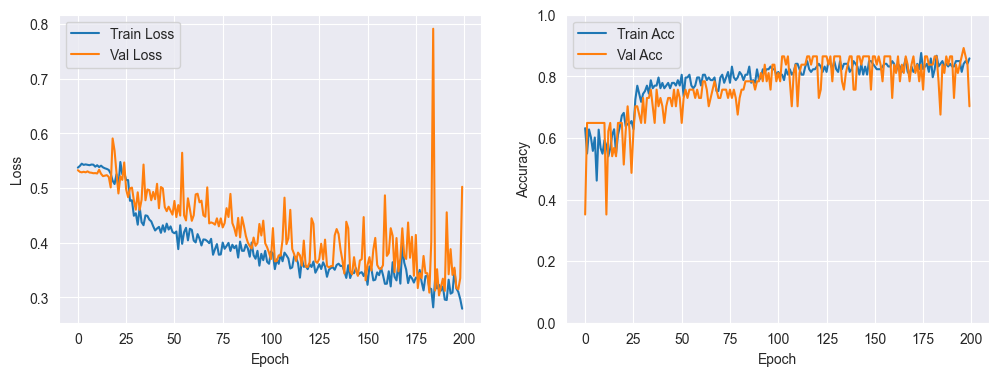

In [25]:
# Train model
history = train(model, train_loader, val_loader, criterion, optimiser, epochs=epochs)

# Plot training history
plot_training_history(history)

In [26]:
# Testing
results = test(model, test_data, criterion)

print(results["report"])

              precision    recall  f1-score   support

         0.0       0.67      0.44      0.53         9
         1.0       0.84      0.93      0.88        28

    accuracy                           0.81        37
   macro avg       0.75      0.69      0.71        37
weighted avg       0.80      0.81      0.80        37



## Part 3: Incorporating Edge Features

---

In [27]:
# TODO